# Collaboration and Competition

This is the report for the Collaboration and Competition lab on the Udacity DRLND. It trains an agent using a DDPG model.

## 1. Install and Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name='Tennis.app')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24


## Train the Model

This environment has a single agent playing against a clone of itself. The agent is a ddpg agent taken from ddpg2.py. The actor network is a 3 layer fully connected model with batch normalization and the critic is a 4 layer fully connected model. The state space is a concatenation of the current agent's state and the opposing agent's state. The replay buffer is prioritized and set to a small value to encourage learning from the most recent opponent's behavior. Gamma is set to 1 so that it prioritizes actions that result in easy situations for the opponent. A noise value is added to the environment to give additional exploration in early cases. The agent is trained

In [2]:
from ddpg2 import Agent
from collections import deque
import torch
from torch import optim
from time import time, sleep


eps = 1.
eps_decay = 0.99
gamma = 1.
n_episodes = 200000
max_t = 2000
agent = Agent(state_size*2, action_size,
              buffer_size=int(2e4), batch_size=128)

# keep track of progress    
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100) 
adj_scores_window = None
best_score = 0.
for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations               # get the current state
    state = np.concatenate([state, state[::-1]], 1)
    score = np.zeros(2, dtype=float)
    adj_score = np.zeros(len(state), dtype=float)
    for t in range(max_t):
        action = agent.act(state, eps)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations      # get the next state
        next_state = np.concatenate([next_state, next_state[::-1]], 1)
        done = env_info.local_done                    # see if episode has finished
        reward = env_info.rewards                    # get the reward
        adj_reward = np.array(reward)
        agent.step(state, action, adj_reward, next_state, done)

        state = next_state
        score += reward
        adj_score += adj_reward#[0]
        if any(done):
            break 
    for _ in range(20):
        agent.learn(gamma, False)
    eps *= eps_decay
    if eps < 0.01:
        eps = 0.
    scores_window.append(np.max(score))       # save most recent score
    adj_scores_window = np.max(adj_score) if adj_scores_window is None else 0.95 * adj_scores_window + 0.05 * np.max(adj_score)
    if adj_scores_window > best_score:
        torch.save(agent.actor_local.state_dict(), 'checkpoint.pth')
    scores.append(score)              # save most recent score
    print('\rEpisode {}\tAverage Score: {:.2f} ({:.2f})'.format(i_episode, np.mean(scores_window), np.mean(adj_scores_window)), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f} ({:.2f})'.format(i_episode, np.mean(scores_window), np.mean(adj_scores_window)))
    if np.mean(scores_window) > 0.5:
        print('\nEnvironment fit in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
        break

Episode 100	Average Score: 0.01 (0.00)
Episode 200	Average Score: 0.02 (0.03)
Episode 300	Average Score: 0.08 (0.11)
Episode 400	Average Score: 0.33 (0.43)
Episode 434	Average Score: 0.50 (0.88)
Environment fit in 334 episodes!	Average Score: 0.50


In [3]:
torch.load('checkpoint.pth', agent.actor_local.state_dict())

OrderedDict([('fc1.weight',
              tensor([[-0.0139, -0.0815, -0.0020,  ...,  0.1481, -0.0272,  0.0555],
                      [ 0.0238, -0.0769,  0.0353,  ...,  0.1631, -0.0080,  0.0563],
                      [-0.0170, -0.1584, -0.0012,  ...,  0.0724, -0.0335, -0.0602],
                      ...,
                      [ 0.0430, -0.1262, -0.0437,  ...,  0.0124,  0.0208,  0.0368],
                      [-0.0261,  0.1367, -0.0130,  ..., -0.0062, -0.0969,  0.0504],
                      [-0.0053, -0.1047, -0.0654,  ...,  0.1175,  0.0525, -0.0479]])),
             ('fc1.bias',
              tensor([ 0.0065,  0.1202,  0.1281,  0.1196, -0.0566,  0.0869, -0.0517, -0.0211,
                       0.0572, -0.1196, -0.0595,  0.0943, -0.1499, -0.0034, -0.0979,  0.1339,
                      -0.1348, -0.0620, -0.0849, -0.1170,  0.1500,  0.0903, -0.1132, -0.1245,
                      -0.0199, -0.1040,  0.1333,  0.1662, -0.1356, -0.0464, -0.0837,  0.0141,
                       0.0573,  0.11

In [4]:
!pip install matplotlib

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


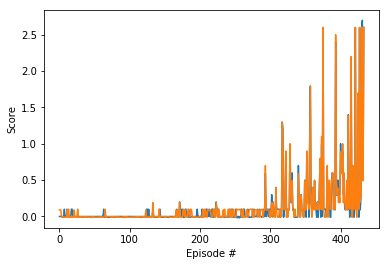

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.ion()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Result

The agent was tested and acheived a score of 2.650000039488077

In [8]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
states = np.concatenate([states, states[::-1]], 1)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states) # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    next_states = np.concatenate([next_states, next_states[::-1]], 1)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 2.650000039488077


## Future Improvements

Potential improvements include adding stochastisity to the models for capturing uncertainty, using random network distilation to improve its early exploration, and adding shared weights for featurization of the state.